In [6]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from collections import OrderedDict
import pylab
import seaborn as sns
import scipy.stats as stats
import math
import json

import sympy as sp
sp.init_printing() 

In [7]:
def parse_file(file_path):
    all_lines = []
    with open(file_path) as file:
        for line in file:
            all_lines.append(line.strip())


    records = []
    for i in np.arange(len(all_lines)):
        if (all_lines[i] == '{'):
            start = i
            while (all_lines[i] != '}'):
                i+=1

            end = i+1
            record_lines = all_lines[start: end]
            record_str = ''.join(record_lines)

            record = json.loads(record_str)

            records.append(record)

    return records

def filter_records(df):
    sd = df.std(axis=0)
    mean = df.mean(axis=0)

    df_filter = pd.DataFrame(columns=['x','y', 'theta'])

    for index, row in df.iterrows():
        x = row['x']
        y = row['y']
        theta  = row['theta']

        range_multiplier = 2
        min_x = mean.x - (range_multiplier*sd.x)
        max_x = mean.x + (range_multiplier*sd.x)

        min_y = mean.y - (range_multiplier*sd.y)
        max_y = mean.y + (range_multiplier*sd.y)

        min_theta = mean.theta - (range_multiplier*sd.theta)
        max_theta = mean.theta + (range_multiplier*sd.theta)

        if (x >= min_x and x <= max_x) and \
            (y >= min_y and y <= max_y)and \
            (theta >= min_theta and theta <= max_theta):
                df_filter = df_filter.append({'x':x, 'y':y, 'theta': theta}, ignore_index=True)
    return df_filter

def get_mean(file_path):   
    records = parse_file(file_path)
    
    df = pd.DataFrame(columns=['x', 'y', 'theta'])
    for _, record in enumerate(records):
        df =df.append({'x': record['position'][0], 'y':record['position'][1], 'theta': record['orientation'][0]}, ignore_index=True)
        
    total_records = df.shape[0]
    
    df = filter_records(df)
    filtered_records = total_records - df.shape[0]
        
    return np.mean(df.x.values), np.mean(df.y.values), np.mean(df.theta.values), filtered_records

def get_measurements(size, direction):
    df = pd.DataFrame(columns=['x', 'y', 'theta'])
    total_filtered = 0
    
    for ind in np.arange(20):
        file_path = './log-data/{}_{}_{:02d}.txt'.format(size.lower(), direction.lower(), ind)
        x,y,theta, dropped = get_mean(file_path)
        df = df.append({'x':x, 'y':y, 'theta':theta}, ignore_index=True)
        
        total_filtered = total_filtered + dropped
        
    return df, total_filtered

def plot_pose(point, angle, marker,color, length=0.5, label = ""):
    '''
    point - Tuple (x, y)
    angle - Angle you want your end point at in degrees.
    length - Length of the line you want to plot.

    Will plot the line on a 10 x 10 plot.
    '''

    # unpack the first point
    x, y = point

    # find the end point
    endy = y+(length * math.sin(angle))
    endx = x+(length * math.cos(angle))
    
    plt.plot([x, endx], [y, endy],color = color,label=label + ' pose')
    
def plot_data(df, gt_end, title='', show=True):
    # measured pose
    plt.scatter(df.x.values, df.y.values, marker='o', color='y')
    for index, row in df.iterrows():
        plot_pose((row['x'], row['y']), angle=row['theta'], marker='o', color='y', label = 'Observed')

    # end pose
    plt.scatter(gt_end[0], gt_end[1], marker='o', color='r')
    plot_pose(point=(gt_end[0], gt_end[1]), angle=gt_end[2],marker='o',color='r',label = 'Expected')
    
    # Initial pose
    plt.scatter(-85.41, -55.60, marker='o', color='g')
    plot_pose(point=(-85.41, -55.60), angle=1.38,marker='o',color='g',label = 'Initial')

    plt.rcParams["figure.figsize"] = (12,6)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(title)
    plt.xlabel("X-axis (cm)")
    plt.ylabel("Y-axis (cm)")
    plt.grid(True)
    
    if(show):
        plt.show()

Total filtered records:  495
Average filtered records:  2.75


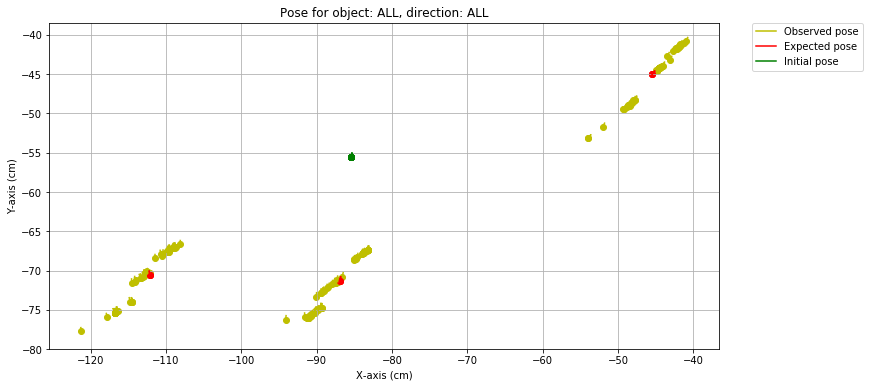

In [12]:
poles = ['small', 'medium', 'large']
directions = ['straight', 'left', 'right']
gt = [[-86.89, -71.31, 1.45], [-45.47, -45.00, 0.88], [-112.13, -70.58, 1.78]]

df_all = pd.DataFrame(columns=['size', 'direction', 'x', 'y', 'theta'])
total_filtered = 0

for _, pole in enumerate(poles):
    for ind, direction in enumerate(directions):
        df, filtered = get_measurements(pole, direction)
        total_filtered = total_filtered + filtered
        
        # Save data
        output_path = './pre-processed/{}_{}.csv'.format(pole, direction)
        df.to_csv(output_path)
        
        x_mean = np.mean(df.x.values)
        y_mean = np.mean(df.y.values)
        theta_mean = np.mean(df.theta.values)
        
        df_all = df_all.append({'size': pole, 'direction': direction, 'x': x_mean, 'y': y_mean, 'theta': theta_mean}, ignore_index=True)
        
        # Plot data
        title=''
        plot_data(df, (gt[ind][0], gt[ind][1], gt[ind][2]), show=False)
        
print 'Total filtered records: ', total_filtered
print 'Average filtered records: ', total_filtered/180.0
        
df_all.to_csv('./pre-processed/all.csv')

plt.title('Pose for object: ALL, direction: ALL')
plt.show()

In [150]:
def get_ground_truth():
    return {'straight': [-86.89, -71.31, 1.45], 
          'left': [-45.47, -45.00, 0.88], 
          'right': [-112.13, -70.58, 1.78]
         }

def scatter_plot_in_direction(direction):
    # ground truth
    gt = get_ground_truth()
        
    pole = 'small'
    title = 'Pose for object: {}, direction: {}'.format(pole, direction)
    df_small, _ = get_measurements(pole, direction)
    plot_data(df_small, (gt[direction][0], gt[direction][1], gt[direction][2]), title)

    pole = 'medium'
    title = 'Pose for object: {}, direction: {}'.format(pole, direction)
    df_medium, _ = get_measurements(pole, direction)
    plot_data(df_medium, (gt[direction][0], gt[direction][1], gt[direction][2]), title)

    pole = 'large'
    title = 'Pose for object: {}, direction: {}'.format(pole, direction)
    df_large, _ = get_measurements(pole, direction)
    plot_data(df_large, (gt[direction][0], gt[direction][1], gt[direction][2]), title)
    
    
    df_all = pd.DataFrame(columns=['x','y', 'theta'])

    df_all = df_all.append(df_small)
    df_all = df_all.append(df_medium)
    df_all = df_all.append(df_large)
    
    title = 'Pose for object: ALL, direction: {}'.format(direction)
    plot_data(df_all, (gt[direction][0], gt[direction][1], gt[direction][2]), title)

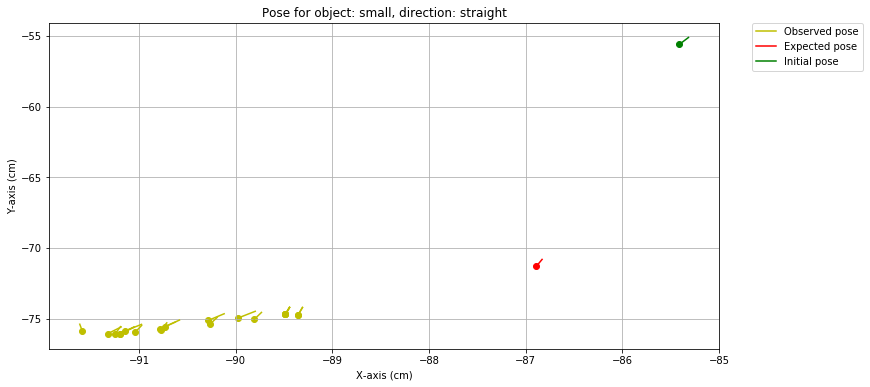

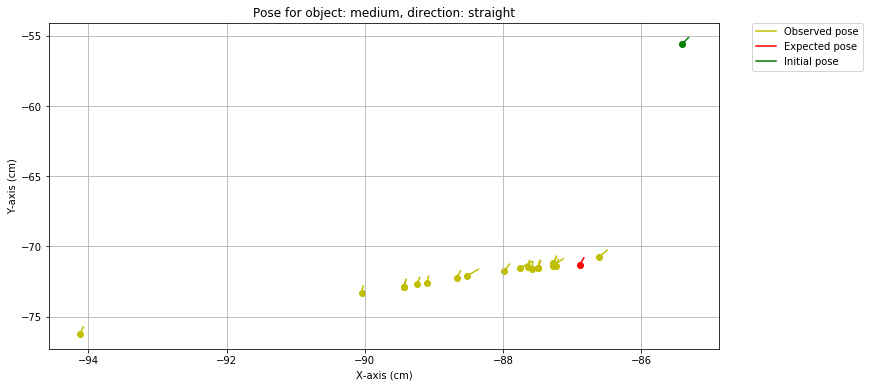

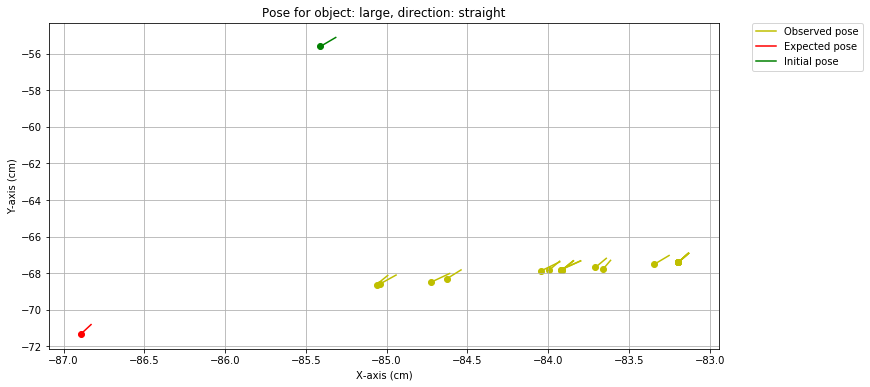

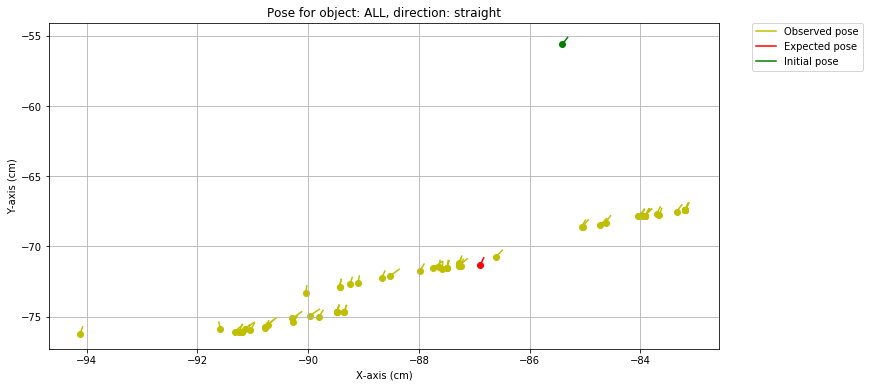

In [151]:
scatter_plot_in_direction('straight')

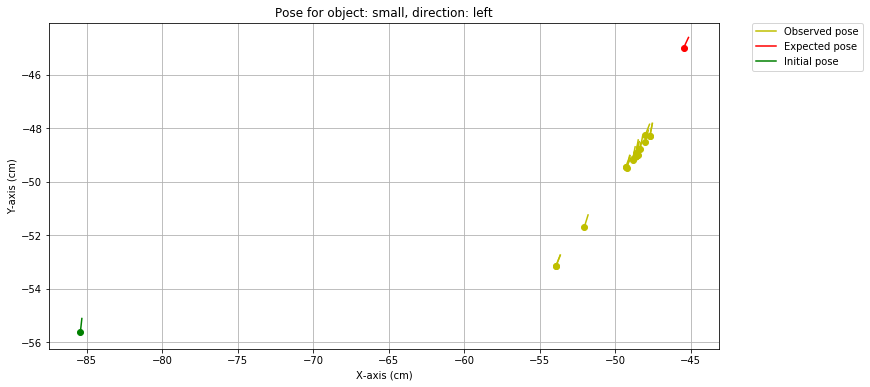

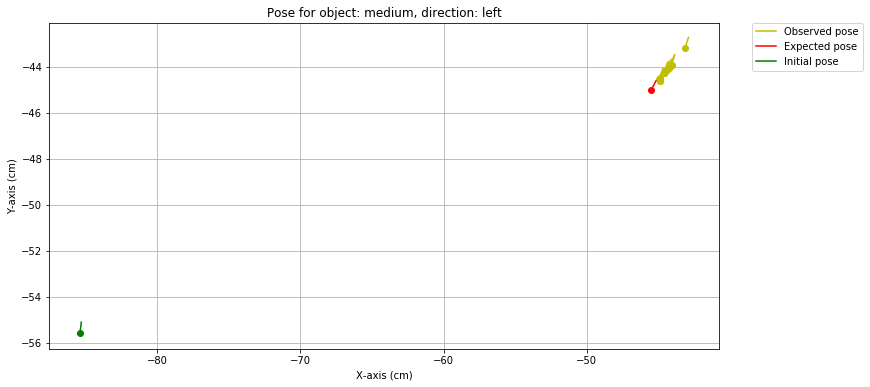

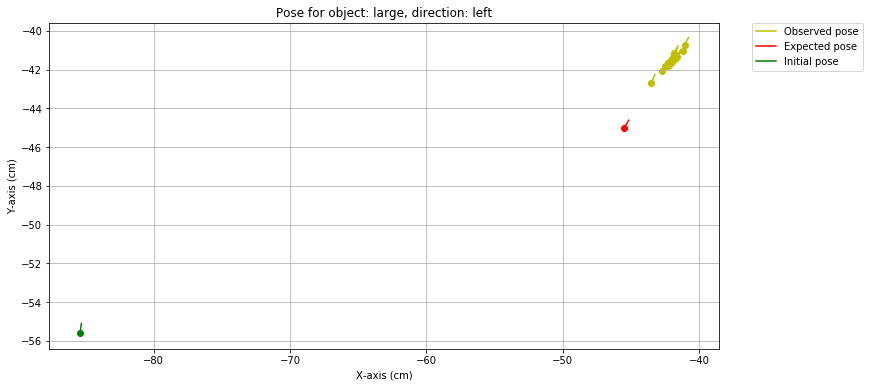

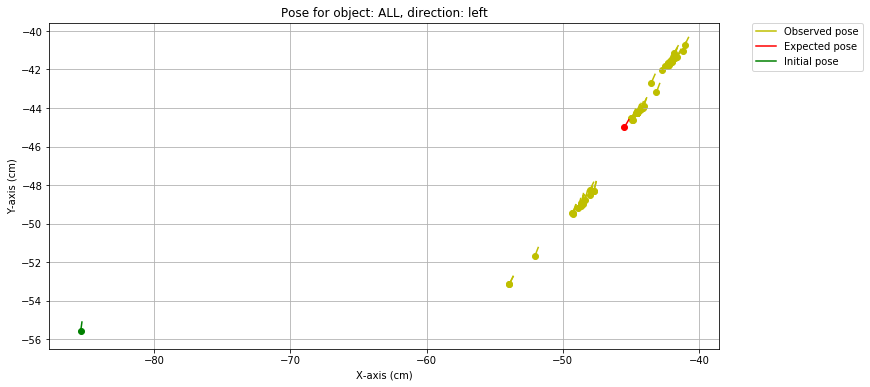

In [152]:
scatter_plot_in_direction('left')

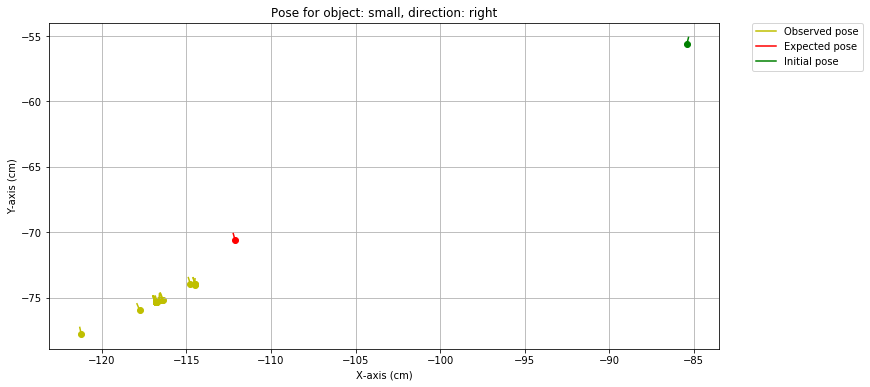

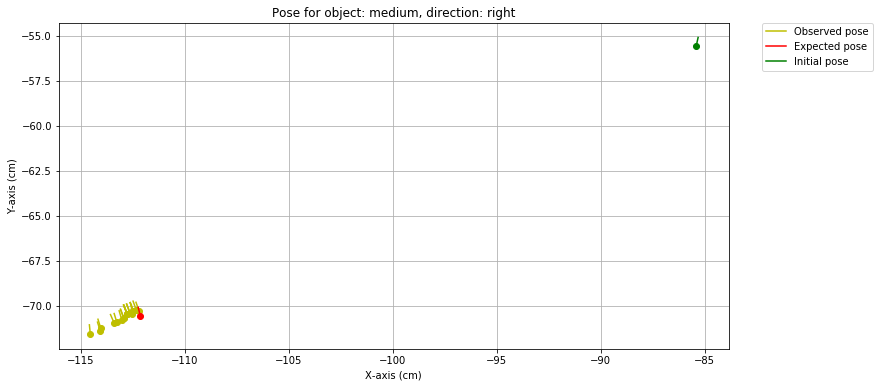

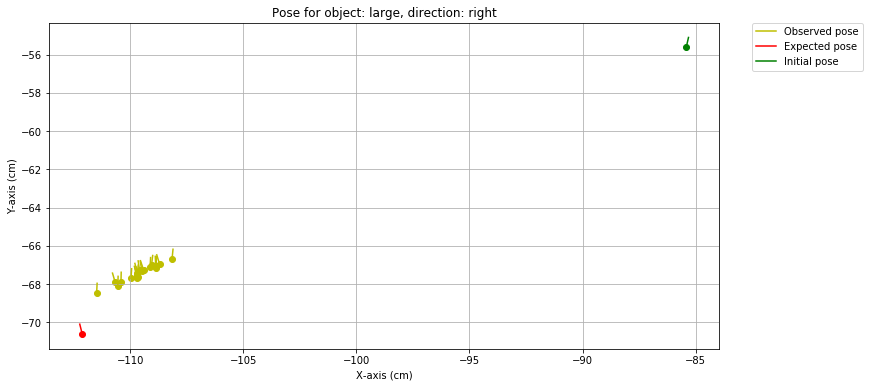

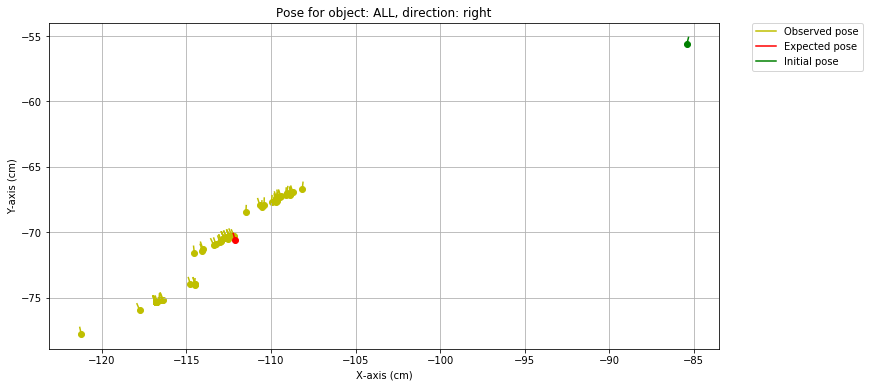

In [153]:
scatter_plot_in_direction('right')

In [154]:
def bar_chart_in_direction(direction):
    pole = 'small'
    df_small, _ = get_measurements(pole, direction)

    pole = 'medium'
    df_medium, _ = get_measurements(pole, direction)

    pole = 'large'
    df_large, _ = get_measurements(pole, direction)

    df_all = pd.DataFrame(columns=['x','y', 'theta'])

    df_all = df_all.append(df_small)
    df_all = df_all.append(df_medium)
    df_all = df_all.append(df_large)

    fig = plt.figure(figsize=(16,16))

    ax = plt.subplot(321)
    sns.distplot(df_small.x.values,hist=True, rug=True,
                 label='object: {}, direction: {}'.format('small', direction))
    plt.title('X coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    ax = plt.subplot(322)
    sns.distplot(df_small.y.values,hist=True, rug=True,
                 label='object: {}, direction: {}'.format('small', direction))
    plt.title('Y coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()


    ax = plt.subplot(323)
    sns.distplot(df_medium.x.values,hist=True, rug=True,
                 label='object: {}, direction: {}'.format('medium', direction))
    plt.title('X coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    ax = plt.subplot(324)
    sns.distplot(df_medium.y.values,hist=True, rug=True,
                 label='object: {}, direction: {}'.format('medium', direction))
    plt.title('Y coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()


    ax = plt.subplot(325)
    sns.distplot(df_large.x.values,hist=True, rug=True,
                 label='object: {}, direction: {}'.format('large', direction))
    plt.title('X coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    ax = plt.subplot(326)
    sns.distplot(df_large.y.values,hist=True, rug=True,
                 label='object: {}, direction: {}'.format('large', direction))
    plt.title('Y coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    plt.show()


    ax = plt.subplot(121)
    sns.distplot(df_all.x.values,hist=True, rug=True,
                 label='object: {}, direction: {}'.format('ALL', direction))
    plt.title('X coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    ax = plt.subplot(122)
    sns.distplot(df_all.y.values,hist=True, rug=True,
                 label='object: {}, direction: {}'.format('ALL', direction))
    plt.title('Y coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    plt.show()

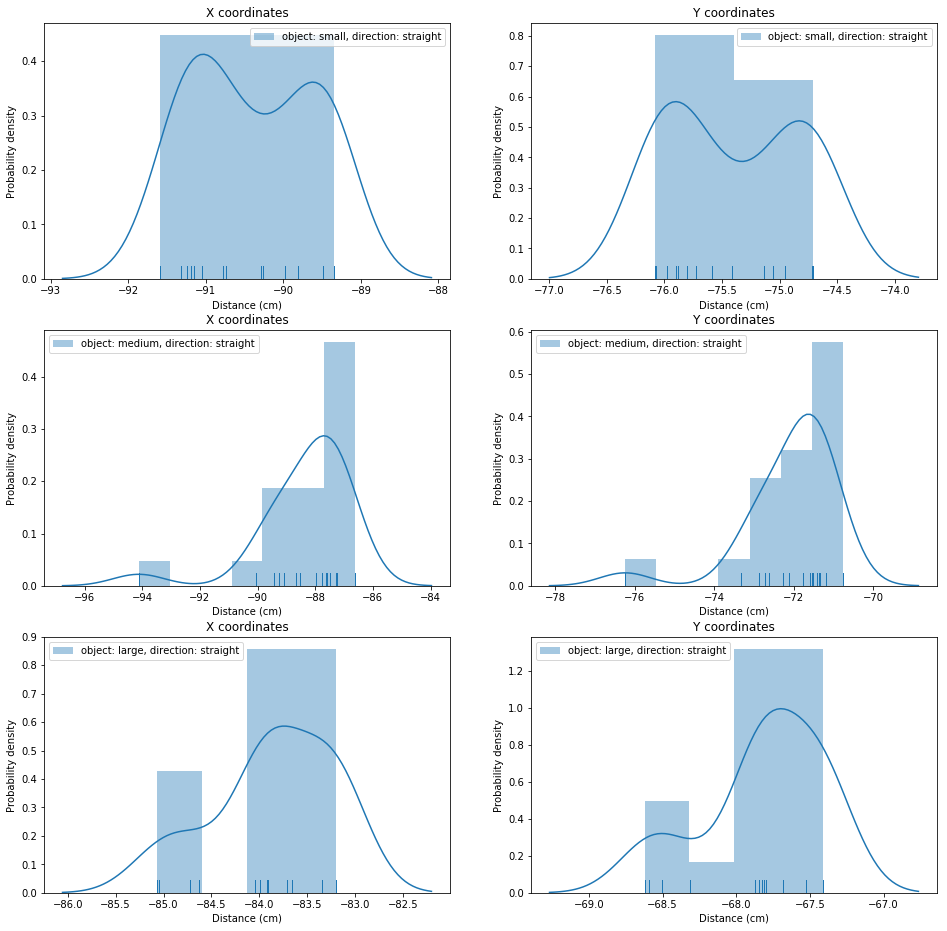

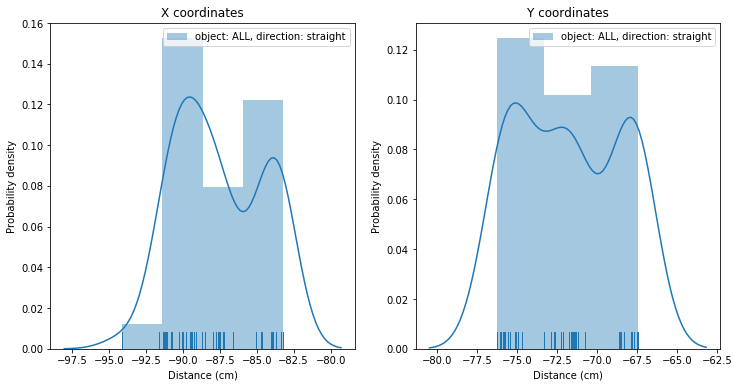

In [155]:
bar_chart_in_direction('straight')

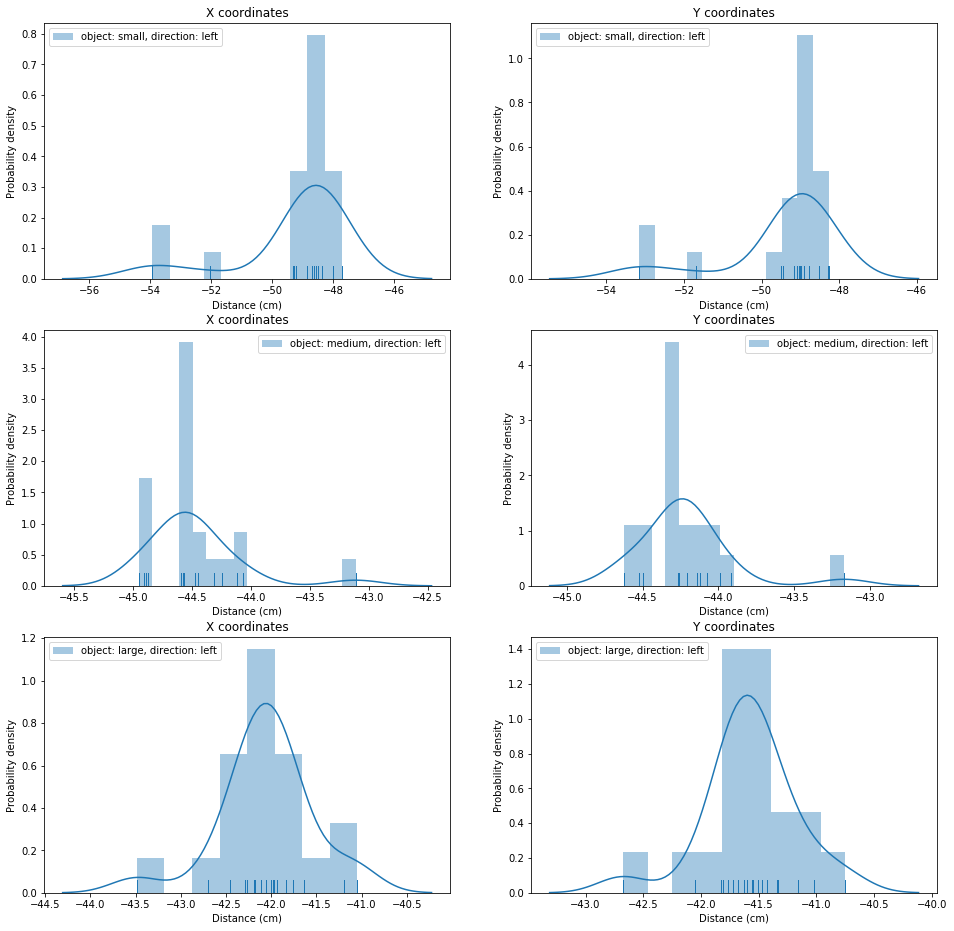

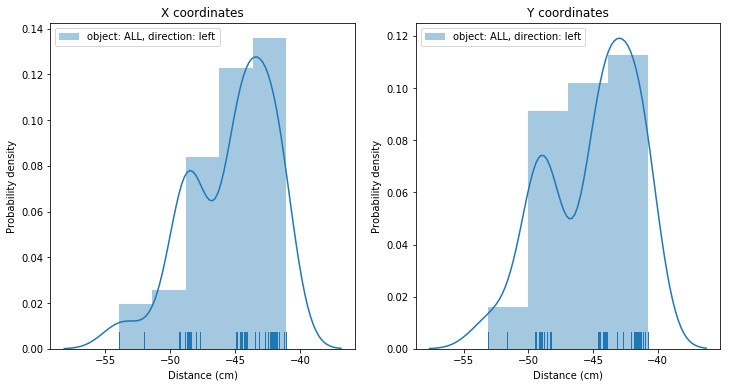

In [156]:
bar_chart_in_direction('left')

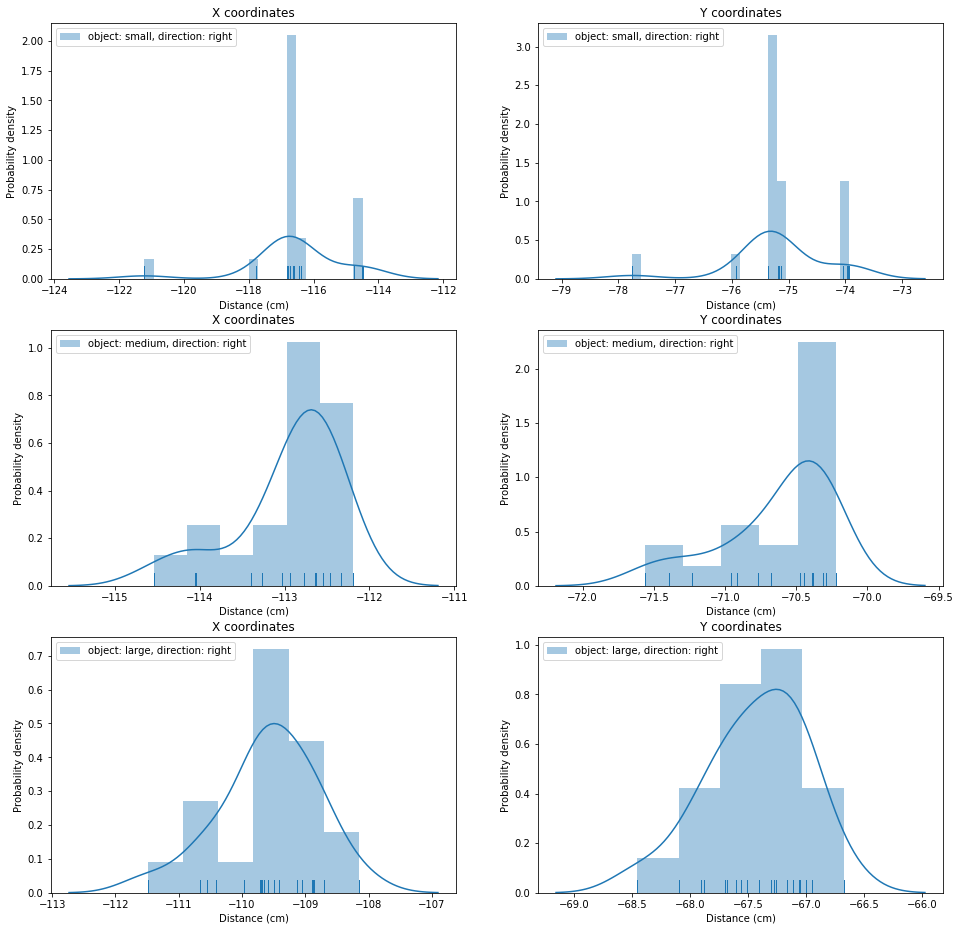

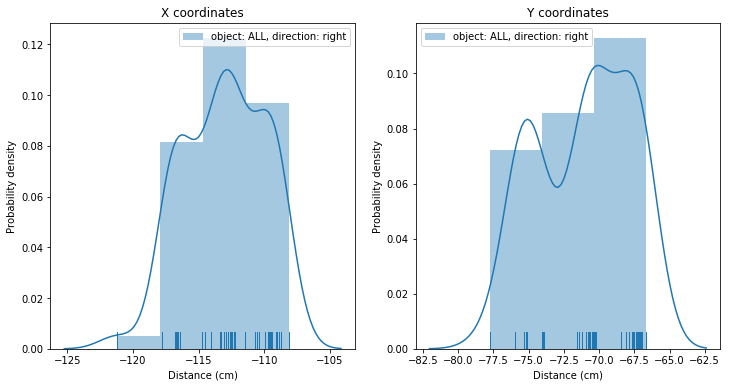

In [157]:
bar_chart_in_direction('right')

In [164]:
def print_mean_in_direction(direction):
    pole = 'small'
    df_small, _ = get_measurements(pole, direction)

    pole = 'medium'
    df_medium, _ = get_measurements(pole, direction)

    pole = 'large'
    df_large, _ = get_measurements(pole, direction)

    df_all = pd.DataFrame(columns=['x','y', 'theta'])

    df_all = df_all.append(df_small)
    df_all = df_all.append(df_medium)
    df_all = df_all.append(df_large)

    mean = df_small.mean(axis=0)
    print 'small: ', mean.x, mean.y, mean.theta

    mean = df_medium.mean(axis=0)
    print 'medium: ', mean.x, mean.y, mean.theta 

    mean = df_large.mean(axis=0)
    print 'large: ', mean.x, mean.y, mean.theta 

    mean = df_all.mean(axis=0)
    print 'all: ', mean.x, mean.y, mean.theta 

In [165]:
print_mean_in_direction('straight')

small:  -90.3993836952614 -75.39984832248788 1.388511093950458
medium:  -88.3832341702218 -72.10142579376027 1.4536456829881066
large:  -83.84838067641223 -67.81584964937433 1.4101854815838917
all:  -87.54366618063183 -71.77237458854083 1.417447419507486


In [166]:
print_mean_in_direction('left')

small:  -49.261607421107364 -49.49407684811267 1.133406067301392
medium:  -44.47662119676369 -44.2135954369016 0.863777273374183
large:  -42.06030568523406 -41.57746402072183 0.9315250439378184
all:  -45.26617810103505 -45.09504543524538 0.9762361282044639


In [167]:
print_mean_in_direction('right')

small:  -116.57199024147125 -75.18979669587354 1.789070106815061
medium:  -112.95068349823892 -70.63301430713713 1.8475876020424498
large:  -109.58388339043847 -67.43100549814821 1.6348702366926033
all:  -113.03551904338288 -71.08460550038633 1.7571759818500376
